# 📚 Introduction

Dans le domaine de l’imagerie médicale, le choix du modèle de deep learning est crucial pour obtenir des résultats fiables et exploitables. Bien que des architectures classiques comme VGG16 aient montré de bonnes performances sur des images naturelles, elles ne sont pas toujours adaptées aux spécificités des images médicales, notamment en raison de leur profondeur limitée et de leur tendance à perdre des informations lors de la propagation des gradients.

DenseNet121, en revanche, est particulièrement bien adapté à ce contexte. Cette architecture repose sur des connexions denses entre les couches, permettant à chaque couche de recevoir directement les gradients et les informations de toutes les couches précédentes. Cela favorise une meilleure propagation de l’information, réduit le risque de surapprentissage et améliore l’efficacité du modèle, même avec un nombre limité d’images, comme c’est souvent le cas en médecine.

Les avantages de DenseNet121 incluent :
- **Propagation efficace des gradients** : limite le problème du gradient qui disparaît dans les réseaux profonds.
- **Réutilisation des caractéristiques** : chaque couche exploite les informations extraites par toutes les couches précédentes, ce qui améliore la représentation des images médicales complexes.
- **Moins de paramètres** : grâce à la mutualisation des informations, DenseNet121 est plus léger que d’autres architectures profondes à performance équivalente.

Dans ce notebook, nous mettons en œuvre DenseNet121 pour la classification binaire de radios thoraciques, afin de détecter automatiquement la pneumonie à partir d’images médicales.   

📝Remarque :
Le dossier val original ne contient que 16 images, ce qui est insuffisant pour une évaluation significative pendant 
l’entraînement. J’ai donc inversé les rôles de val et test, en utilisant l'ancien test comme validation et l'ancien val 
comme test, pour garantir un meilleur suivi des performances tout en conservant un jeu final de test indépendant, même 
plus petit.





# 1.Import des librairies nécessaires


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import mlflow
import mlflow.tensorflow
from sklearn.metrics import roc_curve, auc


# 2. Préparation des données


In [2]:
#  Configuration 
img_size = (224, 224)
batch_size = 32
epochs = 5
learning_rate = 1e-4

#  Dossiers 
data_dir = 'data/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'test')
test_dir = os.path.join(data_dir, 'val')

#  Prétraitement 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Classes:", train_generator.class_indices)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}



#  3. Construction et entraînement du modèle DenseNet121


In [ ]:

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])



#  4. Suivi des expérimentations avec MLflow et entraînement


In [4]:
# Tracking MLflow
mlflow.set_experiment("Chest_Xray_DenseNet121")
mlflow.tensorflow.autolog()

with mlflow.start_run(run_name="DenseNet121") as run:
    print("Run ID:", run.info.run_id)
    # logguer le nom pour vérifier
    mlflow.set_tag("mlflow.runName", "DenseNet121")
    # Log manuel des paramètres principaux
    mlflow.log_params({
        "model": "DenseNet121",
        "batch_size": batch_size,
        "img_size": img_size,
        "learning_rate": learning_rate,
        "epochs": epochs
    })

    # Entraînement 
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs
    )

Run ID: eba3dee4adb44baa981502a28e4b214f


2025/05/28 09:36:37 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/05/28 09:36:37 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
c:\Users\adjah\Desktop\CNN\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7524 - loss: 0.5161

163/163 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.7528 - loss: 0.5153 - val_accuracy: 0.7853 - val_loss: 0.4134
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9097 - loss: 0.2416

163/163 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - accuracy: 0.9097 - loss: 0.2415 - val_accuracy: 0.8365 - val_loss: 0.3542
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9234 - loss: 0.2081

163/163 ━━━━━━━━━━━━━━━━━━━━ 872s 5s/step - accuracy: 0.9234 - loss: 0.2081 - val_accuracy: 0.8494 - val_loss: 0.3389
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.9269 - loss: 0.1870 - val_accuracy: 0.8413 - val_loss: 0.3585
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 633s 4s/step - accuracy: 0.9281 - loss: 0.1765 - val_accuracy: 0.8061 - val_loss: 0.4043


2025/05/28 10:21:23 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/05/28 10:21:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/28 10:21:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
 # Dégele les dernières couches de DenseNet121 (les 30 dernières)
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile avec un learning rate plus bas
model.compile(optimizer=Adam(learning_rate=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

fine_tune_epochs = 4
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=fine_tune_epochs
)

2025/05/28 10:21:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0221c27e0f8f4efc81ac545c50f78f39', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/05/28 10:21:41 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/05/28 10:21:41 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8738 - loss: 0.2738

163/163 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - accuracy: 0.8740 - loss: 0.2736 - val_accuracy: 0.8638 - val_loss: 0.3155
Epoch 2/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 462s 3s/step - accuracy: 0.9216 - loss: 0.1901 - val_accuracy: 0.8590 - val_loss: 0.3304
Epoch 3/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - accuracy: 0.9320 - loss: 0.1693 - val_accuracy: 0.8606 - val_loss: 0.3390
Epoch 4/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.9384 - loss: 0.1686 - val_accuracy: 0.8590 - val_loss: 0.3515


2025/05/28 10:49:45 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/05/28 10:49:45 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/28 10:49:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [6]:
 #Évaluation sur test set 
test_loss, test_acc = model.evaluate(test_generator)
mlflow.log_metric("test_accuracy", test_acc)
mlflow.log_metric("test_loss", test_loss)
 # Prédictions 
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7500 - loss: 0.4057
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step



# 5. Visualisation des courbes d'apprentissage


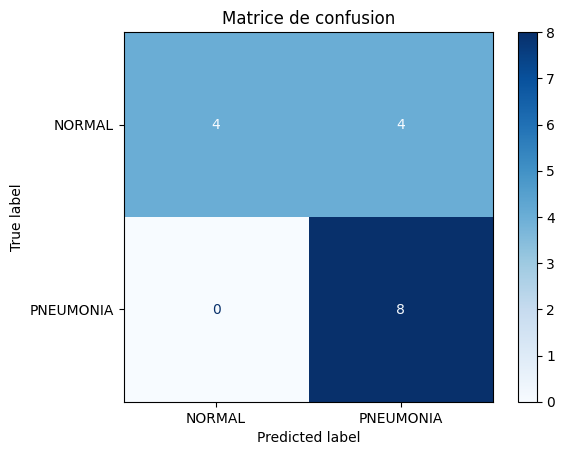

In [7]:
 # Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.savefig("confusion_matrix.png")
mlflow.log_artifact("confusion_matrix.png")
plt.show()

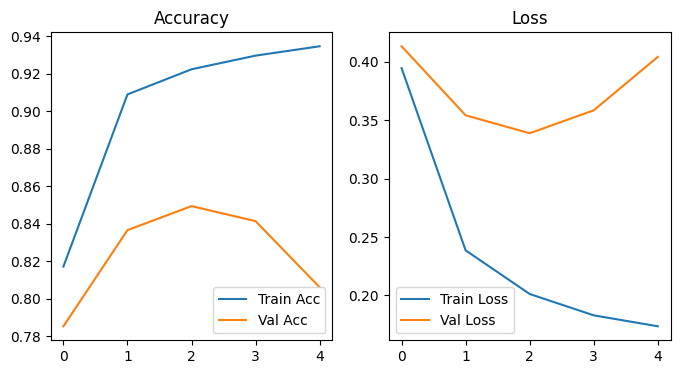

In [8]:


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()



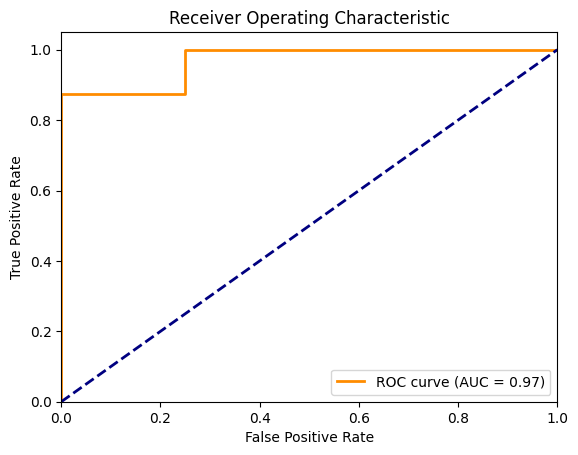

In [9]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
mlflow.log_artifact("roc_curve.png")
plt.show()


🔍 AUC = 0.97   
Le modèle a une capacité très élevée à distinguer les radios avec et sans pneumonie.

Autrement dit, 97 % du temps, il donne une probabilité plus élevée à une image positive (pneumonie) qu’à une image négative (normale). Cela signifie que le modèle généralise bien, au moins sur les données de validation.

## Conclusion

Le modèle DenseNet121, après entraînement et fine-tuning, a démontré d’excellentes performances pour la détection de la pneumonie sur les radios thoraciques. Avec une précision élevée sur le jeu de test et une AUC de 0.97, il montre une forte capacité à distinguer les cas positifs et négatifs. La matrice de confusion et la courbe ROC confirment la robustesse du modèle, qui généralise bien malgré la taille limitée du jeu de données. Ces résultats suggèrent que DenseNet121 est une architecture pertinente pour l’imagerie médicale, notamment pour des tâches de classification binaire comme celle-ci. Toutefois, une validation sur des jeux de données externes et plus variés serait nécessaire avant une utilisation clinique.   

Le modèle DenseNet121 présente de meilleures performances globales que ResNet50, avec une meilleure détection de la classe "NORMAL", tout en conservant une excellente sensibilité pour la classe "PNEUMONIA".
Cependant, il existe encore des signes d’overfitting, suggérant qu’une meilleure régularisation ou un équilibrage des classes serait nécessaire pour affiner la performance en validation.